## A custom Model
This notebook shows how to implement and train a model other than the baseline used for this challenge.

In [1]:
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))


import torch

from utils import creating_dataset


### Load data

In [2]:
DATA_PATH = r"C:\Users\aliam\OneDrive\Desktop\Диплом\dataset\dataset_v2_blocks\dataset_v2_blocks"
data_paths = dict(datasets=[DATA_PATH],
                    hand_type = ['left', 'right'], # [left, 'right']
                    human_type = ['health', 'amputant'], # [amputant, 'health']
                    test_dataset_list = ['fedya_tropin_standart_elbow_left'])
data_config = creating_dataset.DataConfig(**data_paths)
train_dataset, test_dataset = creating_dataset.get_datasets(data_config, )

Here is test path (debug sell) [WindowsPath('C:/Users/aliam/OneDrive/Desktop/Диплом/dataset/dataset_v2_blocks/dataset_v2_blocks/health/right/alex_kovalev_standart_elbow_right/preproc_angles/test'), WindowsPath('C:/Users/aliam/OneDrive/Desktop/Диплом/dataset/dataset_v2_blocks/dataset_v2_blocks/health/left/sema_duplin_standart_elbow_left/preproc_angles/test'), WindowsPath('C:/Users/aliam/OneDrive/Desktop/Диплом/dataset/dataset_v2_blocks/dataset_v2_blocks/health/left/alex_kovalev_standart_elbow_left/preproc_angles/test'), WindowsPath('C:/Users/aliam/OneDrive/Desktop/Диплом/dataset/dataset_v2_blocks/dataset_v2_blocks/health/right/sema_duplin_standart_elbow_right/preproc_angles/test'), WindowsPath('C:/Users/aliam/OneDrive/Desktop/Диплом/dataset/dataset_v2_blocks/dataset_v2_blocks/health/left/petya_chizhov_standart_elbow_left/preproc_angles/test'), WindowsPath('C:/Users/aliam/OneDrive/Desktop/Диплом/dataset/dataset_v2_blocks/dataset_v2_blocks/amputant/left/fedya_tropin_standart_elbow_left/pr

In [340]:
print(test_dataset[1][0].shape, test_dataset[1][1].shape)
print(len(test_dataset))
print(test_dataset[791][0].shape, test_dataset[791][1].shape)

(8, 256) (20, 32)
792
(8, 256) (20, 32)


In [341]:
len(test_dataset.datasets)

1

## Define model
We define a simple Multi Layer Perceptron, fully connected feedforward neural network with 2 hidden layers. The model is implemented using PyTorch.

In [342]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.layers(x)

Try making a prediction using this model.

In [343]:

X, Y = train_dataset[0]
print(f"X shape: {X.shape}, Y shape: {Y.shape}")

n_inputs, n_outputs = X.shape[0], Y.shape[0]
n_hidden = 64

model = MLP(n_inputs, n_hidden, n_outputs)


Y_hat = model(torch.tensor(X.T)).detach().numpy().T
print(f"Predictions shape: {Y_hat.shape}")


X shape: (8, 256), Y shape: (20, 32)
Predictions shape: (20, 256)


As upi cam see. The model's predictions are of the wrong shape: the outputs are not downsampled! Remember that inputs are sampled at 200Hz, but outputs are meant to be at 25Hz. We need to downsample the outputs to match the expected shape.

You can choose your own downsampling method, but make sure that your predictions are aligned to the targets!

In [344]:
import numpy as np

def simple_downsample(x: np.ndarray) -> np.ndarray:
    return x[:, ::data_config.down_sample_target]

Y_hat = model(torch.tensor(X.T)).detach().numpy().T
Y_hat = simple_downsample(Y_hat)


assert Y.shape == Y_hat.shape, "Predictions have the wrong shape!"

For simplicity, you can build the downsampling into your model

In [345]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.layers = torch.nn.Sequential(
        torch.nn.Linear(input_size, hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size, hidden_size//2),
        #torch.nn.Dropout(p=0.1),
        torch.nn.Linear(hidden_size//2, hidden_size//4),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size//4, hidden_size//8),
        #torch.nn.Dropout(p=0.1),
        torch.nn.Linear(hidden_size//8, output_size)
    )


    def forward(self, x):
        x = self.layers(x)
        return x[::data_config.down_sample_target, :]
    

model = MLP(n_inputs, n_hidden, n_outputs)

Y_hat = model(torch.tensor(X.T)).detach().numpy().T
assert Y.shape == Y_hat.shape, "Predictions have the wrong shape!"

## Training

We define a very simple training procedure.

In [346]:
n_epochs = 1
lr = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(n_inputs, n_hidden, n_outputs).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss()

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    
    epoch_loss = 0
    for X,Y in train_dataset:
        X, Y = torch.tensor(X.T).to(device), torch.tensor(Y).to(device)
        Y_hat = model(X).T

        loss = criterion(Y_hat, Y)
        loss.backward()
        epoch_loss += loss.item()

        optimizer.step()

    print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")

    print(n_inputs, n_hidden, n_outputs)

Epoch 1 Loss: 310263250852807.6875
8 64 20


### Let's plot some predictions

In [347]:
import pandas as pd
X, Y = train_dataset[1]
pd.DataFrame(Y)

0         1         2         3         4         5         6   \
0   0.071431  0.060294  0.052995  0.045484  0.031757  0.024248  0.019678   
1   0.075132  0.075838  0.077262  0.079125  0.080485  0.082719  0.083907   
2   0.324342  0.321882  0.321366  0.321891  0.323694  0.323270  0.319327   
3   0.085960  0.083468  0.081277  0.078838  0.077220  0.075089  0.073741   
4   0.271440  0.263545  0.259615  0.261058  0.261255  0.259437  0.252779   
5   0.123330  0.126063  0.127678  0.128233  0.128298  0.127571  0.128309   
6   0.261690  0.255773  0.253275  0.253294  0.256064  0.258383  0.255418   
7   0.085863  0.082572  0.081327  0.080742  0.082042  0.081983  0.079589   
8   0.404850  0.415472  0.429033  0.452622  0.484916  0.499373  0.499118   
9   0.052028  0.049663  0.049765  0.051672  0.054838  0.056228  0.055294   
10  0.795285  0.762782  0.725285  0.679028  0.623377  0.594703  0.580878   
11  0.502214  0.482381  0.461189  0.435193  0.403723  0.385509  0.376354   
12  0.784987  0.788013  0.788965  0.790332  0.796328  0.798473  0.796788   
13 -0.085028 -0.086434 -0.088365 -0.090468 -0.093590 -0.096154 -0.097116   
14  0.650792  0.644608  0.637474  0.629080  0.615947  0.604002  0.595529   
15  0.342297  0.338584  0.335896  0.333124  0.329170  0.323633  0.318634   
16  0.334209  0.332953  0.332982  0.333397  0.334927  0.337834  0.342090   
17 -0.130562 -0.127796 -0.122925 -0.118732 -0.115608 -0.111344 -0.112772   
18  0.396972  0.396606  0.395729  0.395368  0.395444  0.394046  0.392089   
19  0.147266  0.147730  0.148945  0.149467  0.149399  0.148539  0.148206   

          7         8         9   ...        22        23        24        25  \
0   0.020777  0.022750  0.024463  ...  0.030898  0.031909  0.035704  0.033750   
1   0.084380  0.084321  0.084931  ...  0.096079  0.097160  0.099460  0.102039   
2   0.315810  0.312829  0.309193  ...  0.315017  0.320615  0.326807  0.336693   
3   0.071702  0.070324  0.069145  ...  0.073794  0.076660  0.080478  0.083868   
4   0.246349  0.239136  0.231840  ...  0.209108  0.215313  0.219894  0.225929   
5   0.128213  0.128206  0.129949  ...  0.144137  0.141436  0.137531  0.135060   
6   0.254182  0.253461  0.250081  ...  0.236188  0.243361  0.253332  0.264421   
7   0.077338  0.075247  0.072826  ...  0.053351  0.056006  0.058850  0.064263   
8   0.494521  0.485707  0.478119  ...  0.359321  0.351472  0.336969  0.336528   
9   0.052042  0.047810  0.041650  ... -0.000396  0.002395  0.005892  0.009922   
10  0.571727  0.570644  0.564362  ...  0.630271  0.664501  0.712800  0.740622   
11  0.368802  0.365178  0.359487  ...  0.373772  0.392096  0.418255  0.435710   
12  0.799878  0.800158  0.802236  ...  0.730134  0.725633  0.724553  0.723225   
13 -0.096342 -0.095159 -0.095094  ... -0.096994 -0.095987 -0.094202 -0.093611   
14  0.590281  0.586806  0.581663  ...  0.555919  0.569504  0.585494  0.605189   
15  0.313515  0.308781  0.303734  ...  0.261525  0.266747  0.272861  0.283605   
16  0.341097  0.339355  0.337086  ...  0.322198  0.319781  0.316462  0.314243   
17 -0.114620 -0.118245 -0.121724  ... -0.104431 -0.100241 -0.095747 -0.090689   
18  0.388833  0.387291  0.384541  ...  0.358494  0.358714  0.360250  0.359943   
19  0.148761  0.150576  0.153007  ...  0.175913  0.175210  0.174029  0.172707   

          26        27        28        29        30        31  
0   0.038179  0.040850  0.045581  0.048580  0.052372  0.058049  
1   0.104354  0.105440  0.107251  0.108187  0.108288  0.109289  
2   0.342123  0.348976  0.354200  0.357977  0.359338  0.356961  
3   0.087264  0.089952  0.092476  0.094430  0.095563  0.094440  
4   0.233643  0.237734  0.245156  0.249432  0.250190  0.251879  
5   0.132864  0.131126  0.129419  0.128032  0.127432  0.127720  
6   0.273462  0.280195  0.284373  0.285997  0.286441  0.279904  
7   0.069173  0.073553  0.076880  0.079080  0.081225  0.080585  
8   0.339849  0.341527  0.343695  0.346316  0.349327  0.353720  
9   0.012587  0.015170  0.016957  0.017072  0.016555  0.01509

### Добавила визуализацию

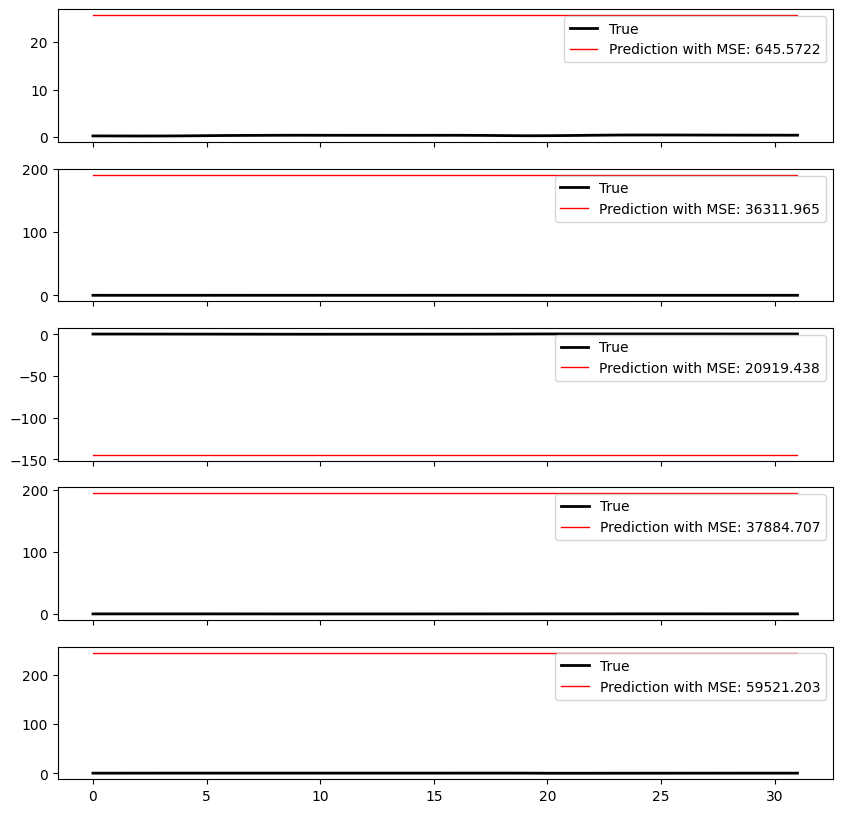

In [348]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE


X, Y = train_dataset[0]

Y_hat = model(torch.tensor(X.T).to(device)).detach().cpu().numpy().T

f, axes = plt.subplots(5, 1, figsize=(10, 10), sharex=True)

labels = []
for i, ax in enumerate(axes):
    labels.append('Prediction with MSE: ' + str(MSE(Y[i], Y_hat[i])))

for i, ax in enumerate(axes):
    ax.plot(Y[i], label="True", lw=2, color='k')
    ax.plot(Y_hat[i], label=labels[i], lw=1, color='r')

    ax.legend()


In [51]:
device = 'cpu'
dtype = torch.float32

weights1 = r"C:\Users\nodos\PycharmProjects\amputants\tutorials\logs\test_2_run_fedya\step_150_loss_0.3714.safetensors"

weights2 = r"C:\Users\nodos\PycharmProjects\amputants\tutorials\logs\test_2_run_fedya\step_600_loss_0.3223.safetensors"

weights3 = r"C:\Users\nodos\PycharmProjects\amputants\tutorials\logs\test_2_run_fedya\step_750_loss_0.3100.safetensors"

weights4 = r"C:\Users\nodos\PycharmProjects\amputants\tutorials\logs\test_2_run_fedya\step_3450_loss_0.2758.safetensors"

MODEL_TYPE = 'hvatnet'
model_config = hvatnet.Config(n_electrodes=8, n_channels_out=20,
                            n_res_blocks=3, n_blocks_per_layer=3,
                            n_filters=128, kernel_size=3,
                            strides=(2, 2, 2), dilation=2, 
                            small_strides = (2, 2))
model = hvatnet.HVATNetv3(model_config)


Number of parameters: 4210788


### Подбор гиперпараметров для модели ALVI Labs

In [49]:
weights5 = r"C:\Users\nodos\PycharmProjects\amputants\tutorials\logs\test_05_11_run_fedya\step_7800_loss_0.2743.safetensors"
MODEL_TYPE = 'hvatnet'
model_config = hvatnet.Config(n_electrodes=8, n_channels_out=20,
                            n_res_blocks=5, n_blocks_per_layer=2,
                            n_filters=128, kernel_size=3,
                            strides=(2, 2, 2), dilation=3, 
                            small_strides = (1, 1))
model = hvatnet.HVATNetv3(model_config)


Number of parameters: 3224676


In [9]:
X, Y = test_dataset[42]

def batch_mse(Y, Y_5):
    Y = np.array(Y)
    Y_5 = np.array(Y_5)
    mse_values = []
    for i in range(len(Y)):
        mse = np.mean((Y[i] - Y_5[i]) ** 2)
        mse_values.append(mse)
    total_mse = np.sum(mse_values)
    print(f"Суммарное MSE по батчу: {total_mse}")
    return total_mse


In [47]:
X, Y = test_dataset[2]

In [54]:
w11 = r"C:\Users\nodos\PycharmProjects\amputants\tutorials\logs\test_05_11_run_fedya\step_150_loss_0.3332.safetensors"
w22 = r"C:\Users\nodos\PycharmProjects\amputants\tutorials\logs\test_05_11_run_fedya\step_750_loss_0.3242.safetensors"
w33 = r"C:\Users\nodos\PycharmProjects\amputants\tutorials\logs\test_05_11_run_fedya\step_1050_loss_0.3068.safetensors"
w44 = r"C:\Users\nodos\PycharmProjects\amputants\tutorials\logs\test_05_11_run_fedya\step_2250_loss_0.2902.safetensors"
w55 = r"C:\Users\nodos\PycharmProjects\amputants\tutorials\logs\test_05_11_run_fedya\step_2850_loss_0.2795.safetensors"
w66 = r"C:\Users\nodos\PycharmProjects\amputants\tutorials\logs\test_05_11_run_fedya\step_7800_loss_0.2743.safetensors"

In [ ]:
steps = [150, 750, 1050, 2250, 2850, 7800]
Y_pred = [Y, Y_1, Y_2, Y_3, Y_4, Y_5, Y_6]
# Создайте список меток для графиков
labels = ['True']
for step in steps:
    labels.append('Step ' + str(step) + ' with MSE: ' + str(batch_mse(Y[i], Y_pred[i])) for i in range(7))

In [72]:
import matplotlib.cm as cm

# Создайте список цветов от красного к зеленому
colors = cm.get_cmap('RdYlGn')(np.linspace(0, 1, 6))

# Создайте список предсказаний для каждого экземпляра модели
steps = [150, 750, 1050, 2250, 2850, 7800]
Y_pred = [Y_1, Y_2, Y_3, Y_4, Y_5, Y_6]
# Создайте список меток для графиков
labels = []
for i, step in enumerate(steps):
    labels.append('Step ' + str(step) + ' with MSE: ' + str(batch_mse(Y, Y_pred[i])))



Суммарное MSE по батчу: 2.1683926582336426
Суммарное MSE по батчу: 1.6405696868896484
Суммарное MSE по батчу: 1.719068169593811
Суммарное MSE по батчу: 1.7919151782989502
Суммарное MSE по батчу: 1.9188023805618286
Суммарное MSE по батчу: 1.9113409519195557


C:\Users\nodos\AppData\Local\Temp\ipykernel_19328\3774183063.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('RdYlGn')(np.linspace(0, 1, 6))


In [73]:
labels

['Step 150 with MSE: 2.1683927',
 'Step 750 with MSE: 1.6405697',
 'Step 1050 with MSE: 1.7190682',
 'Step 2250 with MSE: 1.7919152',
 'Step 2850 with MSE: 1.9188024',
 'Step 7800 with MSE: 1.911341']

In [ ]:
ax.plot(Y[i], label="True", lw=2, color='k')
ax.plot(Y_5[i], label="Ver1.1", lw=1, color='g')

<generator object <genexpr> at 0x0000022A9582C350>


### Разобраться с метриками, что-то странное

Number of parameters: 3224676


C:\Users\nodos\AppData\Local\Temp\ipykernel_19328\654704253.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('RdYlGn')(np.linspace(0, 1, 6))


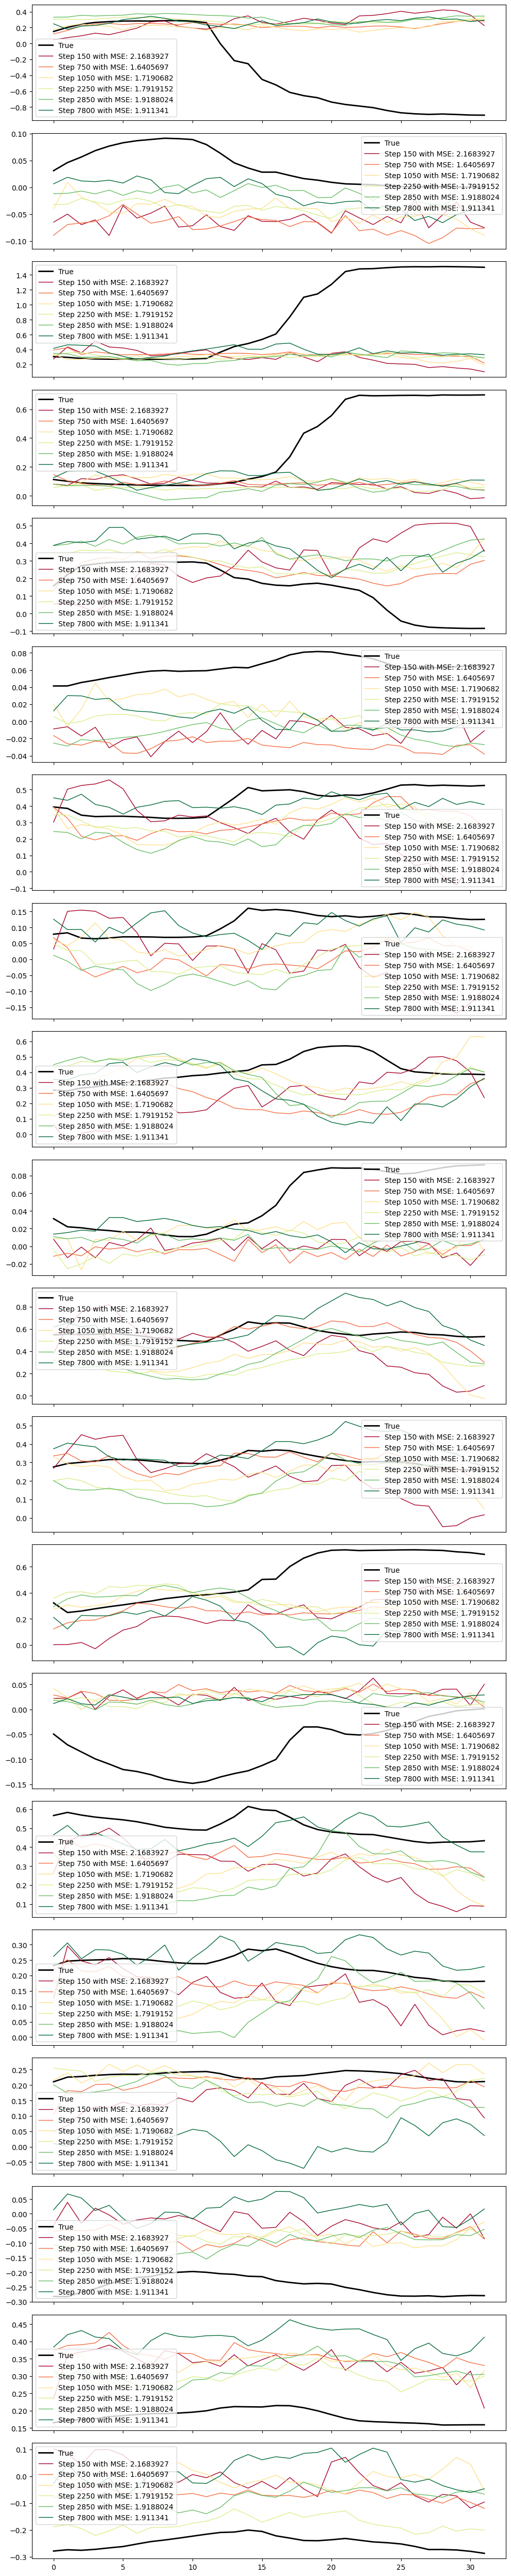

In [75]:
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import matplotlib.cm as cm



weights5 = r"C:\Users\nodos\PycharmProjects\amputants\tutorials\logs\test_05_11_run_fedya\step_7800_loss_0.2743.safetensors"
MODEL_TYPE = 'hvatnet'
model_config = hvatnet.Config(n_electrodes=8, n_channels_out=20,
                            n_res_blocks=5, n_blocks_per_layer=2,
                            n_filters=128, kernel_size=3,
                            strides=(2, 2, 2), dilation=3, 
                            small_strides = (1, 1))
model = hvatnet.HVATNetv3(model_config)
load_model(model, w11)
model1 = model.to(device).to(dtype)
Y_1 = model1(torch.tensor(X).unsqueeze(0)).squeeze().detach().numpy()

load_model(model, w22)
model2 = model.to(device).to(dtype)
Y_2 = model2(torch.tensor(X).unsqueeze(0)).squeeze().detach().numpy()

load_model(model, w33)
model3 = model.to(device).to(dtype)
Y_3 = model3(torch.tensor(X).unsqueeze(0)).squeeze().detach().numpy()

load_model(model, w44)
model4 = model.to(device).to(dtype)
Y_4 = model4(torch.tensor(X).unsqueeze(0)).squeeze().detach().numpy()

load_model(model, w55)
model5 = model.to(device).to(dtype)
Y_5 = model5(torch.tensor(X).unsqueeze(0)).squeeze().detach().numpy()

load_model(model, w66)
model6 = model.to(device).to(dtype)
Y_6 = model6(torch.tensor(X).unsqueeze(0)).squeeze().detach().numpy()

colors = cm.get_cmap('RdYlGn')(np.linspace(0, 1, 6))



f, axes = plt.subplots(20, 1, figsize=(10, 50), sharex=True)

for i, ax in enumerate(axes):
    ax.plot(Y[i], label="True", lw=2, color='k')
    ax.plot(Y_1[i], label=labels[0], lw=1, color=colors[0])
    ax.plot(Y_2[i], label=labels[1], lw=1, color=colors[1])
    ax.plot(Y_3[i], label=labels[2], lw=1, color=colors[2])
    ax.plot(Y_4[i], label=labels[3], lw=1, color=colors[3])
    ax.plot(Y_5[i], label=labels[4], lw=1, color=colors[4])
    ax.plot(Y_6[i], label=labels[5], lw=1, color=colors[5])
    ax.legend()
    

    
plt.tight_layout()
plt.savefig('обновленная архитектура с по эпохам.png', dpi = 500)
plt.show()



### Натянула сглаживание

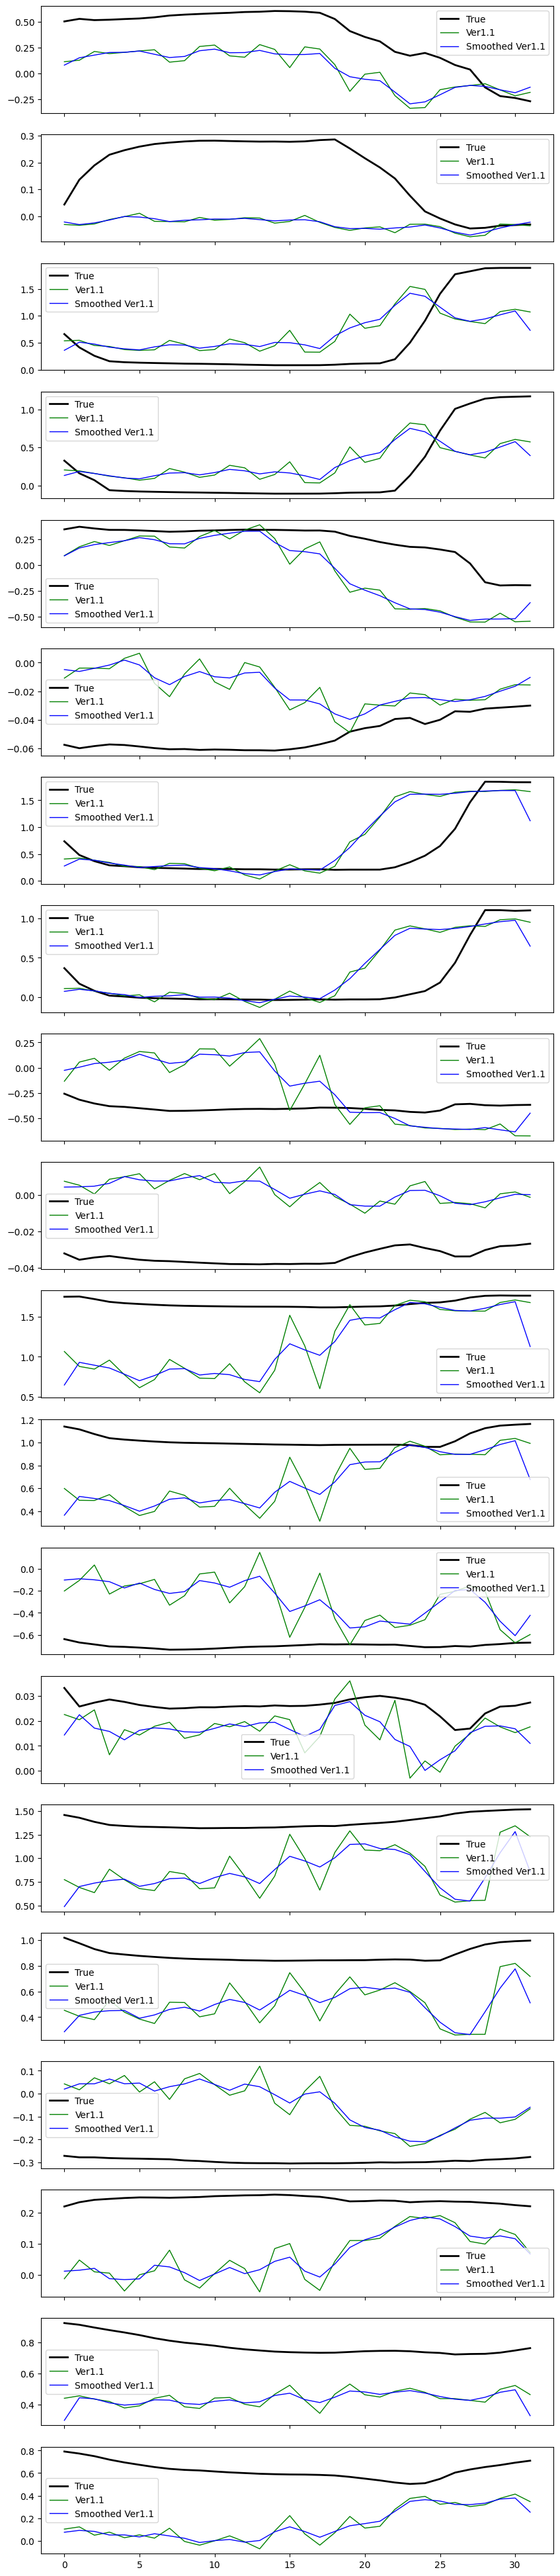

In [60]:
# Функция для вычисления скользящего среднего
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

window_size = 3

f, axes = plt.subplots(20, 1, figsize=(10, 50), sharex=True)

for i, ax in enumerate(axes):
    ax.plot(Y[i], label="True", lw=2, color='k')
    ax.plot(Y_5[i], label="Ver1.1", lw=1, color='g')

    smoothed_Y_5 = moving_average(Y_5[i], window_size)
    ax.plot(smoothed_Y_5, label="Smoothed Ver1.1", lw=1, color='b')

    ax.legend()

plt.show()

In [48]:
Y[5]

array([0.05208977, 0.05437757, 0.05501695, 0.05588047, 0.0579778 ,
       0.05980241, 0.06022478, 0.06149643, 0.06299822, 0.06403559,
       0.06531052, 0.06614078, 0.06691536, 0.06615107, 0.06587035,
       0.06659711, 0.06653356, 0.06698014, 0.06555268, 0.06687155,
       0.06615663, 0.04772081, 0.03875922, 0.03881597, 0.03558571,
       0.0382993 , 0.03741208, 0.03631898, 0.03643751, 0.03609171,
       0.03577681, 0.03432979], dtype=float32)

### А тут моя CNN

### Сначала для одной эпохи и все в одной ячейке, извините

Epoch 1 Loss: 7834.0916


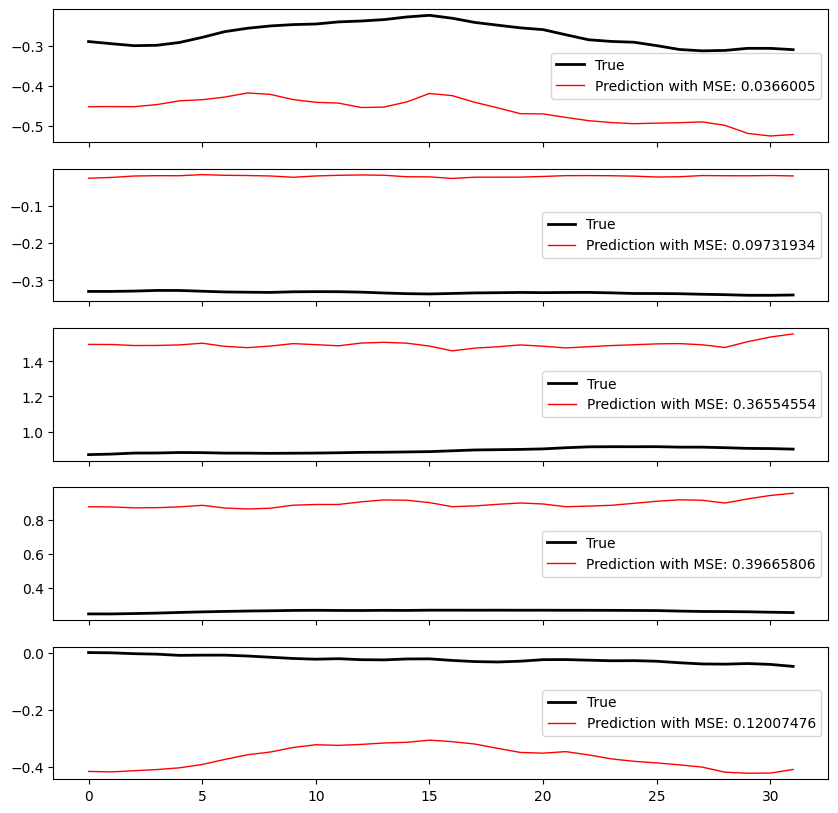

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class CNN(nn.Module):
    def __init__(self, input_channels, output_size, num_joints, pred_length):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(256 * 32, 512) 
        self.fc2 = nn.Linear(512, output_size * pred_length)  
        self.num_joints = num_joints
        self.pred_length = pred_length
        
    def forward(self, x):
        # x shape: (batch_size, input_channels, sequence_length)
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        
        
        x = x.view(x.size(0), -1)  
        
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        
        
        x = x.view(x.size(0), self.num_joints, self.pred_length)
        
        return x

# Параметры модели
input_channels = 8  # Количество ЭМГ датчиков
output_size = 20    # Количество суставов
num_joints = 20     # Количество суставов
pred_length = 32    # Количество кадров


model = CNN(input_channels, output_size, num_joints, pred_length)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


n_epochs = 1
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    
    for X, Y in train_dataset:
        X = torch.tensor(X, dtype=torch.float32).to(device)  # (8, 256)
        Y = torch.tensor(Y, dtype=torch.float32).to(device)  # (20, 32)
        
       
        X = X.unsqueeze(0)  # (1, 8, 256)
        
        optimizer.zero_grad()
        
        
        Y_hat = model(X)  # (1, 20, 32)
        
        # Вычисляем потерю
        loss = criterion(Y_hat.squeeze(0), Y)  
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")

# Пример предсказания
X, Y = train_dataset[0]
X = torch.tensor(X, dtype=torch.float32).to(device).unsqueeze(0)  # (1, 8, 256)
Y_hat = model(X).squeeze(0).detach().cpu().numpy()  # (20, 32)


import matplotlib.pyplot as plt

f, axes = plt.subplots(5, 1, figsize=(10, 10), sharex=True)

labels = []
for i, ax in enumerate(axes):
    labels.append('Prediction with MSE: ' + str(np.mean((Y[i] - Y_hat[i])**2)))

for i, ax in enumerate(axes):
    ax.plot(Y[i], label="True", lw=2, color='k')
    ax.plot(Y_hat[i], label=labels[i], lw=1, color='r')
    ax.legend()

plt.show()

### 5 эпох

In [21]:
model = CNN(input_channels, output_size, num_joints, pred_length)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 5
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    
    for X, Y in train_dataset:
        X = torch.tensor(X, dtype=torch.float32).to(device)  # (8, 256)
        Y = torch.tensor(Y, dtype=torch.float32).to(device)  # (20, 32)
        

        X = X.unsqueeze(0)  # (1, 8, 256)
        
        optimizer.zero_grad()
        

        Y_hat = model(X)  # (1, 20, 32)
        
    
        loss = criterion(Y_hat.squeeze(0), Y)  
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")

Epoch 1 Loss: 7950.6238
Epoch 2 Loss: 7087.0042
Epoch 3 Loss: 7038.1874
Epoch 4 Loss: 7030.8600
Epoch 5 Loss: 7133.6323


### Лоссы начали расти, решила дообучить, но что-то сломалось

In [31]:
n_epochs = 5
model.train()
for epoch in range(n_epochs):
    epoch_loss = 0
    
    for X, Y in train_dataset:
        X = torch.tensor(X, dtype=torch.float32).to(device)  # (8, 256)
        Y = torch.tensor(Y, dtype=torch.float32).to(device)  # (20, 32)
        
        # Добавляем размерность батча
        X = X.unsqueeze(0)  # (1, 8, 256)
        
        optimizer.zero_grad()
        
        # Прямой проход
        Y_hat = model(X)  # (1, 20, 32)
        
        # Вычисляем потерю
        loss = criterion(Y_hat.squeeze(0), Y)  # Убираем размерность батча для сравнения
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+5} Loss: {epoch_loss:.4f}")

KeyboardInterrupt: 

### Предсказание на трейне

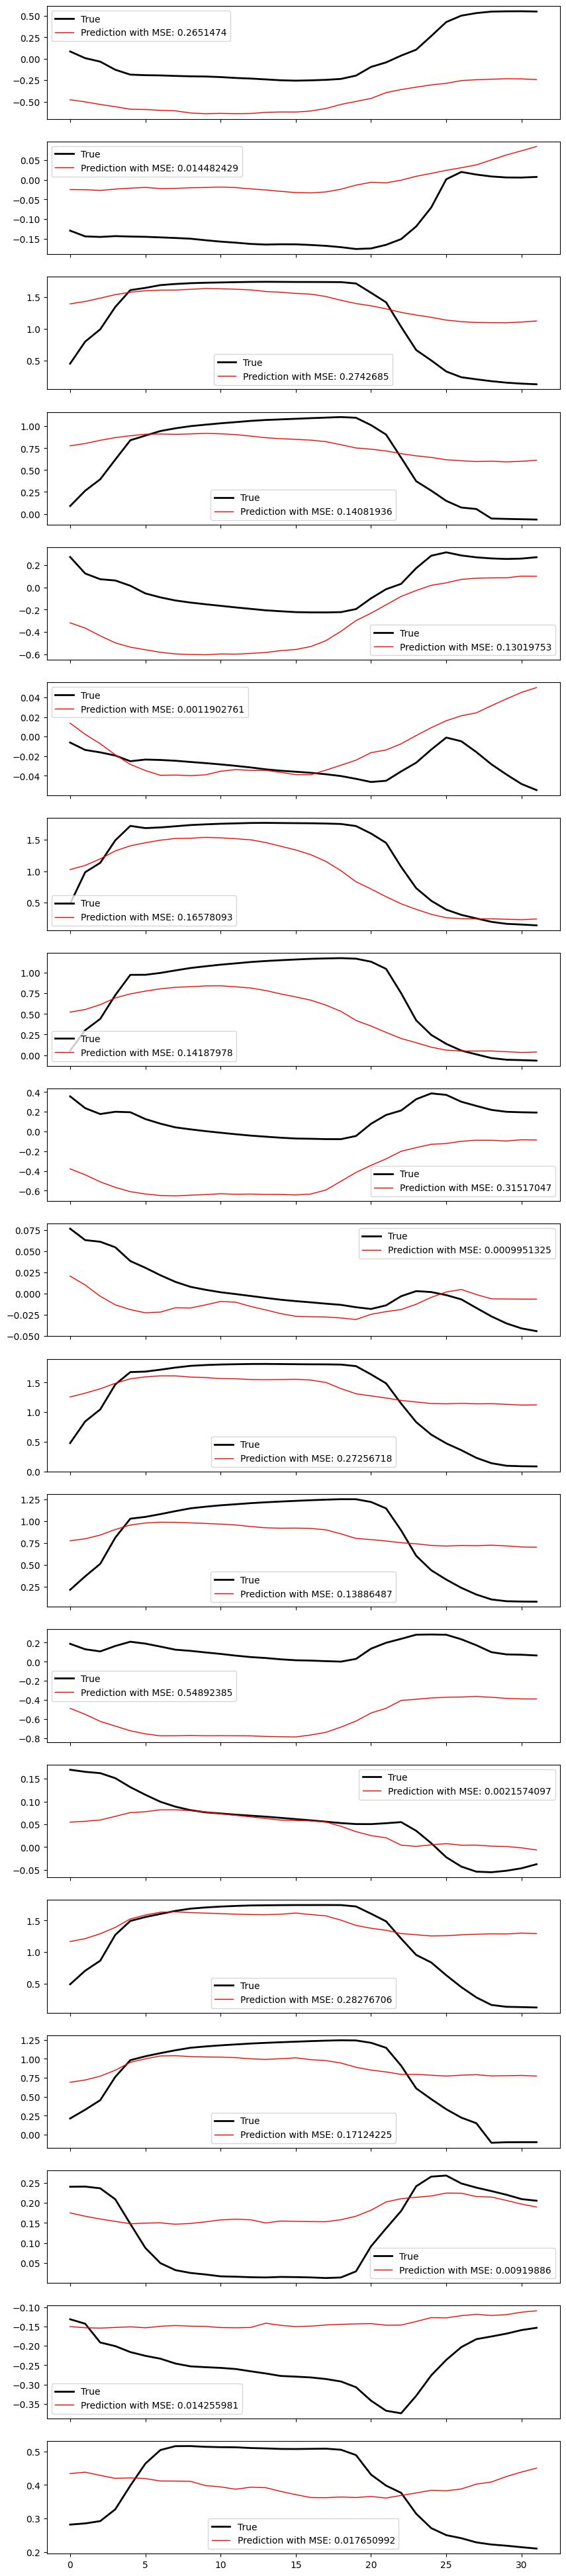

<Figure size 640x480 with 0 Axes>

In [28]:

X, Y = train_dataset[0]
X = torch.tensor(X, dtype=torch.float32).to(device).unsqueeze(0)  # (1, 8, 256)
Y_hat = model(X).squeeze(0).detach().cpu().numpy()  # (20, 32)


import matplotlib.pyplot as plt

f, axes = plt.subplots(19, 1, figsize=(10, 50), sharex=True)

labels = []
for i, ax in enumerate(axes):
    labels.append('Prediction with MSE: ' + str(np.mean((Y[i] - Y_hat[i])**2)))

for i, ax in enumerate(axes):
    ax.plot(Y[i], label="True", lw=2, color='k')
    ax.plot(Y_hat[i], label=labels[i], lw=1, color='r')
    ax.legend()

plt.show()
plt.tight_layout()
plt.savefig('cnn.png', dpi = 500)

### Предсказание на тесте

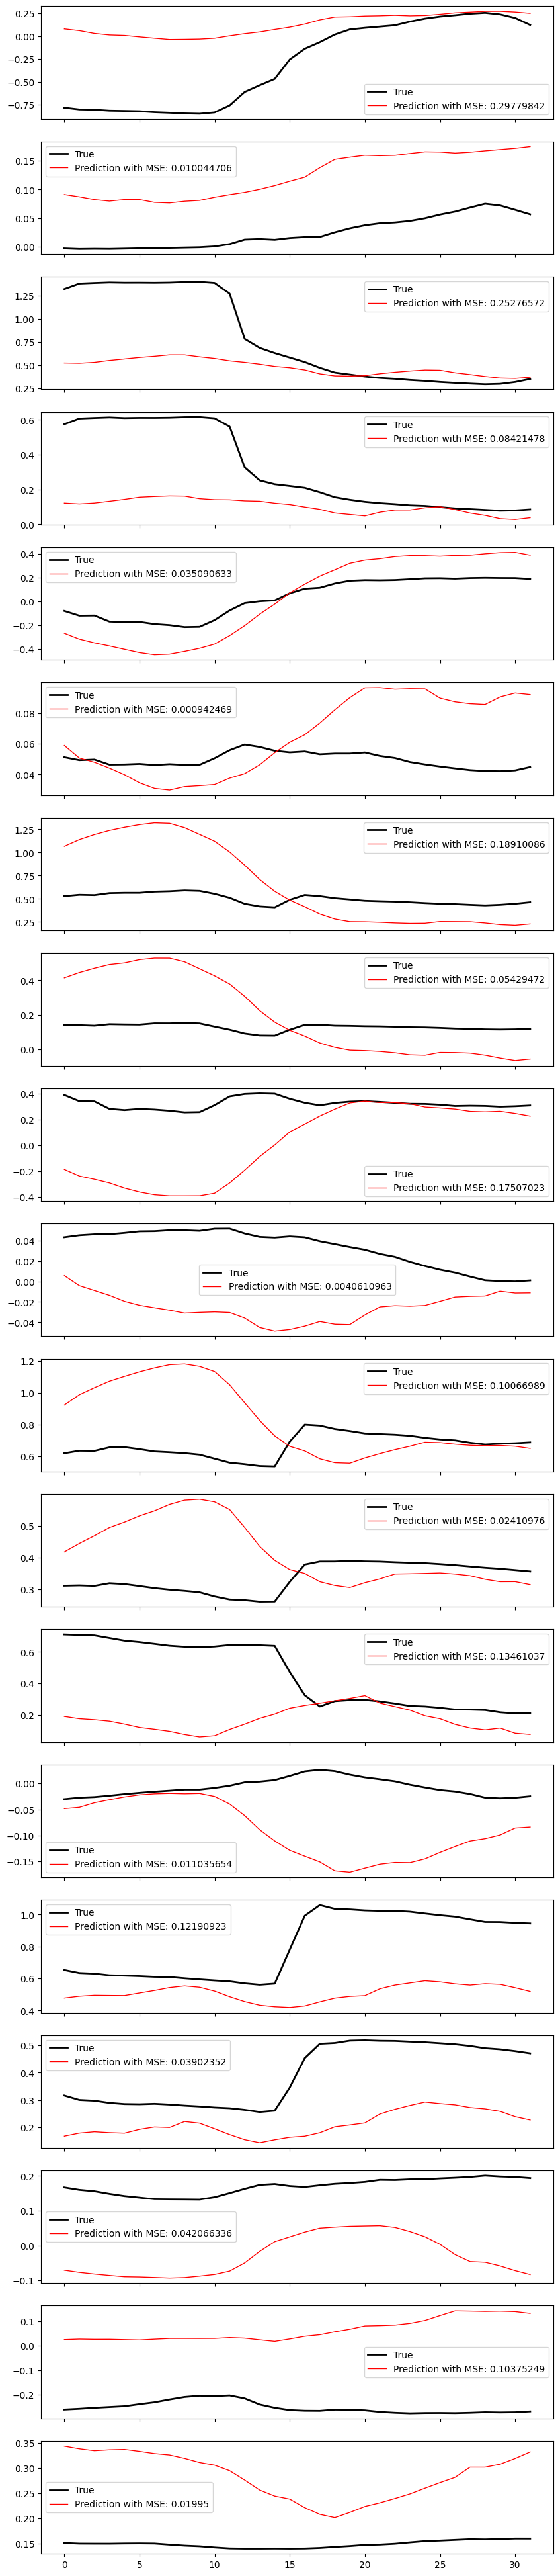

<Figure size 640x480 with 0 Axes>

In [29]:
X, Y = test_dataset[0]
X = torch.tensor(X, dtype=torch.float32).to(device).unsqueeze(0)  # (1, 8, 256)
Y_hat = model(X).squeeze(0).detach().cpu().numpy()  # (20, 32)


import matplotlib.pyplot as plt

f, axes = plt.subplots(19, 1, figsize=(10, 50), sharex=True)

labels = []
for i, ax in enumerate(axes):
    labels.append('Prediction with MSE: ' + str(np.mean((Y[i] - Y_hat[i])**2)))

for i, ax in enumerate(axes):
    ax.plot(Y[i], label="True", lw=2, color='k')
    ax.plot(Y_hat[i], label=labels[i], lw=1, color='r')
    ax.legend()

plt.show()
plt.tight_layout()
plt.savefig('cnn.png', dpi = 500)

In [30]:

torch.save(model.state_dict(), 'cnn_model_1.pth')

### А тут я уже наигралась и поняла, что лучшее предсказания для "движение средним пальцем руки из положения кулак"

In [278]:
import matplotlib.pyplot as plt
import numpy as np

X, Y = test_dataset[106]
X = torch.tensor(X, dtype=torch.float32).to(device).unsqueeze(0)  # (1, 8, 256)
Y_hat = model(X).squeeze(0).detach().cpu().numpy()  # (20, 32)



### Графики для хорошо получившегося жеста и новая метрика nMAE

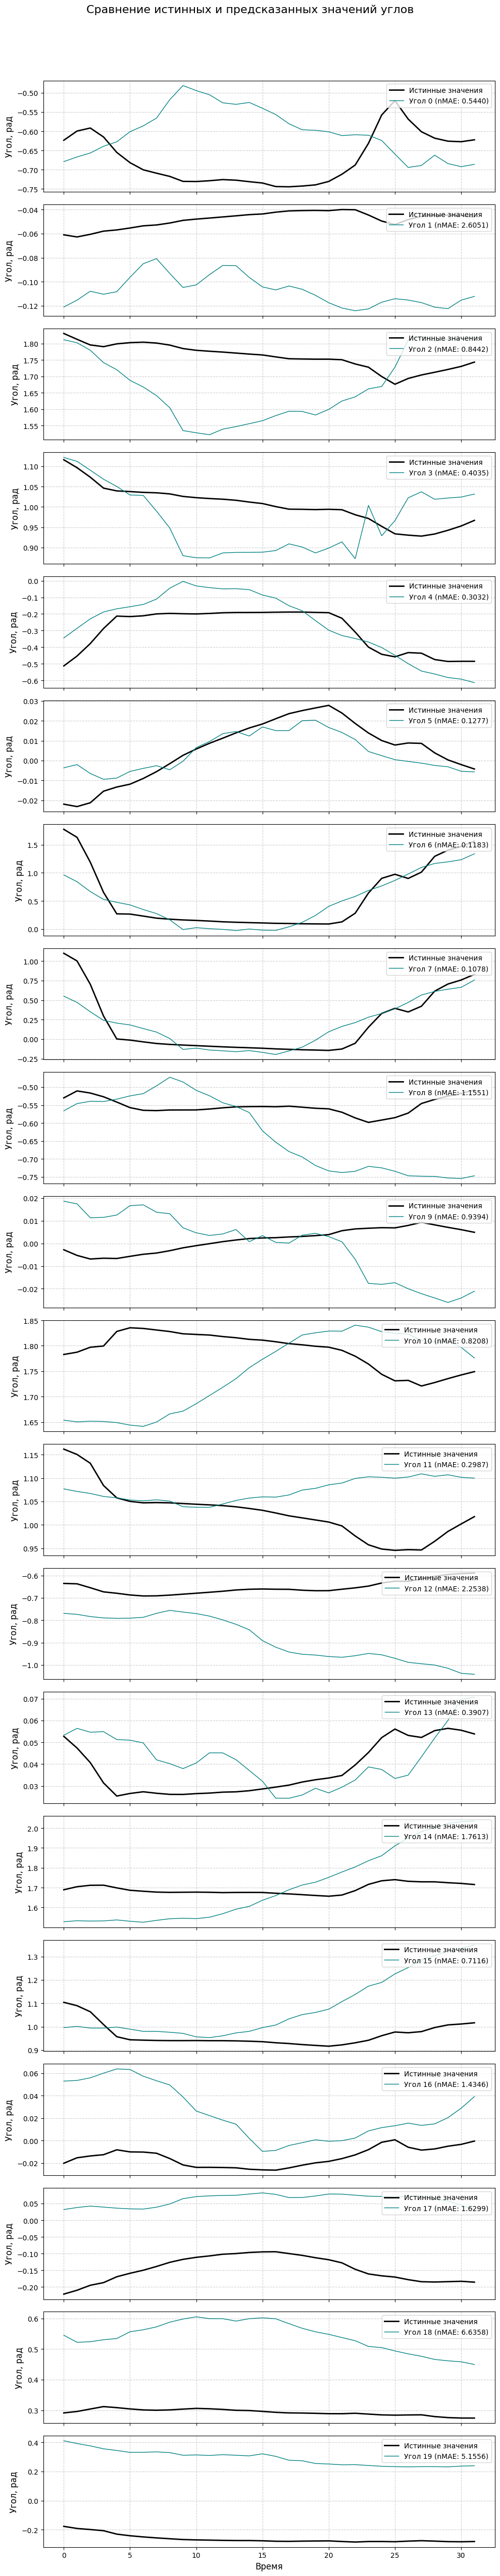

In [279]:

f, axes = plt.subplots(20, 1, figsize=(10, 50), sharex=True)


f.suptitle('Сравнение истинных и предсказанных значений углов', fontsize=16, y=1.02)


labels = []
for i, ax in enumerate(axes):
    mae = sum(abs(Y[i] - Y_hat[i]))/(32*abs((max(Y[i]-min(Y[i])))))  # Тут новая метрика nMAE
    labels.append(f'Угол {i} (nMAE: {mae:.4f})')


for i, ax in enumerate(axes):
    ax.plot(Y[i], label="Истинные значения", lw=2, color='k')  
    ax.plot(Y_hat[i], label=labels[i], lw=1, color='teal')  
    ax.set_ylabel('Угол, рад', fontsize=12)  
    ax.legend(loc='upper right', fontsize=10)  
    ax.grid(True, linestyle='--', alpha=0.6)  


axes[-1].set_xlabel('Время', fontsize=12)

# Улучшаем компоновку и сохраняем график
plt.tight_layout()
plt.savefig('cnn.png', dpi=500)
plt.show()

### Визуализируем истинное движение

In [280]:
from utils.hand_visualize import Hand, save_animation
from utils.quats_and_angles import get_quats
import numpy as np

b = test_dataset[106]
Y = b[1].T
quats = get_quats(Y)

hand_gt = Hand(quats)
ani = hand_gt.visualize_all_frames()
save_animation(ani, 'true_vis.gif', fps=2,)   # this will save a .gif file

### Визуализируем наше предсказание

In [281]:
Y = Y_hat.T
quats = get_quats(Y)
hand_gt = Hand(quats)
ani = hand_gt.visualize_all_frames()
save_animation(ani, 'cnn_vis_106.gif', fps=2,)   # this will save a .gif file

In [203]:
Y_hat_copy = Y_hat.copy()

In [60]:
print(Y_hat_copy[2])

[0.6457124  0.6782861  0.7035833  0.7294926  0.76152426 0.79058284
 0.8168892  0.8435832  0.862334   0.86544526 0.8757989  0.89466333
 0.9328559  0.9571947  0.97596264 0.9740206  0.96612185 0.9649821
 0.96115494 0.96455586 0.9353478  0.9035487  0.8857136  0.863379
 0.85325027 0.84837633 0.8386465  0.81972575 0.7820012  0.7473778
 0.71730113 0.6957029 ]


### Визуализация разности между углами

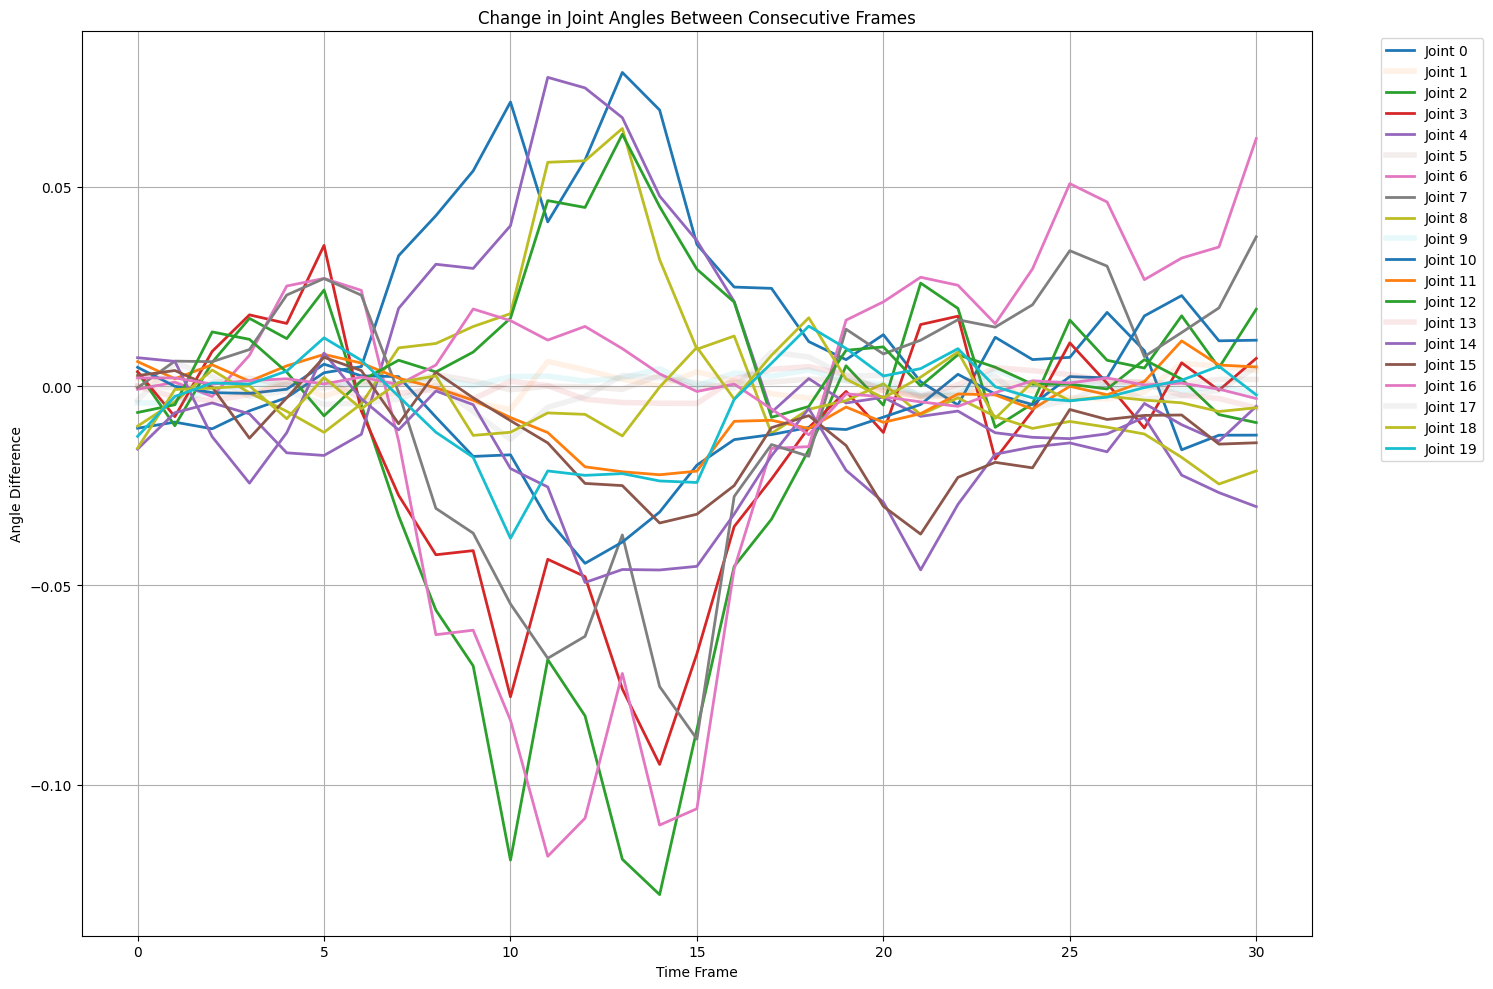

In [ ]:
import matplotlib.pyplot as plt
import numpy as np



# Вычисляем разность между углами для каждого последовательного фрейма
angle_differences = np.diff(Y_hat, axis=1)


plt.figure(figsize=(15, 10))


time = np.arange(angle_differences.shape[1])


for i in range(angle_differences.shape[0]):
    if i in [13, 9, 17, 1, 5]: #list of cringe angles that not changing
        plt.plot(time, angle_differences[i], label=f'Joint {i}', linewidth=4, alpha = 0.1)  
    else: 
        plt.plot(time, angle_differences[i], label=f'Joint {i}', linewidth=2, alpha = 1) 

plt.xlabel('Time Frame')
plt.ylabel('Angle Difference')
plt.title('Change in Joint Angles Between Consecutive Frames')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

### А тут я пыталась понять, какой угол соответсвует какому пальцу, обнуляя движения каждого из них и визуализируя

In [156]:
Y_hat_copy = Y_hat.copy()
zero = [0] * 32
Y_hat_copy[0] = zero
Y_hat_copy[1] = zero
Y_hat_copy[2] = zero
Y_hat_copy[3] = zero
Y_hat_copy[4] = zero
Y_hat_copy[5] = zero
Y_hat_copy[6] = zero
Y_hat_copy[7] = zero
Y_hat_copy[8] = zero
Y_hat_copy[9] = zero
Y_hat_copy[10] = zero
Y_hat_copy[11] = zero
Y_hat_copy[12] = zero
Y_hat_copy[13] = zero
Y_hat_copy[14] = zero
Y_hat_copy[15] = zero
Y_hat_copy[16] = zero
Y_hat_copy[17] = zero
Y_hat_copy[18] = zero
#Y_hat_copy[19] = zero


quats = get_quats(Y_hat_copy.T)
hand_gt = Hand(quats)
ani = hand_gt.visualize_all_frames()
save_animation(ani, 'good_finger.gif', fps=2,)   # this will save a .gif file

In [124]:
Y = Y_hat_copy.T
quats = get_quats(Y)
hand_gt = Hand(quats)
ani = hand_gt.visualize_all_frames()
save_animation(ani, 'cnn_vis_good_finger.gif', fps=2,)   # this will save a .gif file